In [15]:
# 1. Setup & Data Loading
# ================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import (classification_report, confusion_matrix, 
                           roc_auc_score, roc_curve, r2_score, 
                           mean_squared_error, precision_recall_curve)
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import chi2_contingency, ttest_ind

In [16]:
# Load data
df = pd.read_csv('streamworks_user_data.csv')

# ================
# 2. Data Exploration
# ================
print("=== Data Structure ===")
print(df.info())
print("\n=== Descriptive Stats ===")
print(df.describe(include='all'))
print("\n=== Missing Values ===")
print(df.isnull().sum())

=== Data Structure ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   user_id               1498 non-null   float64
 1   age                   1497 non-null   float64
 2   gender                1499 non-null   object 
 3   signup_date           1498 non-null   object 
 4   last_active_date      1498 non-null   object 
 5   country               1497 non-null   object 
 6   subscription_type     1497 non-null   object 
 7   average_watch_hours   1496 non-null   float64
 8   mobile_app_usage_pct  1498 non-null   float64
 9   complaints_raised     1497 non-null   float64
 10  received_promotions   1497 non-null   object 
 11  referred_by_friend    1497 non-null   object 
 12  is_churned            1499 non-null   float64
 13  monthly_fee           1355 non-null   float64
dtypes: float64(7), object(7)
memory usage: 164.2+ KB


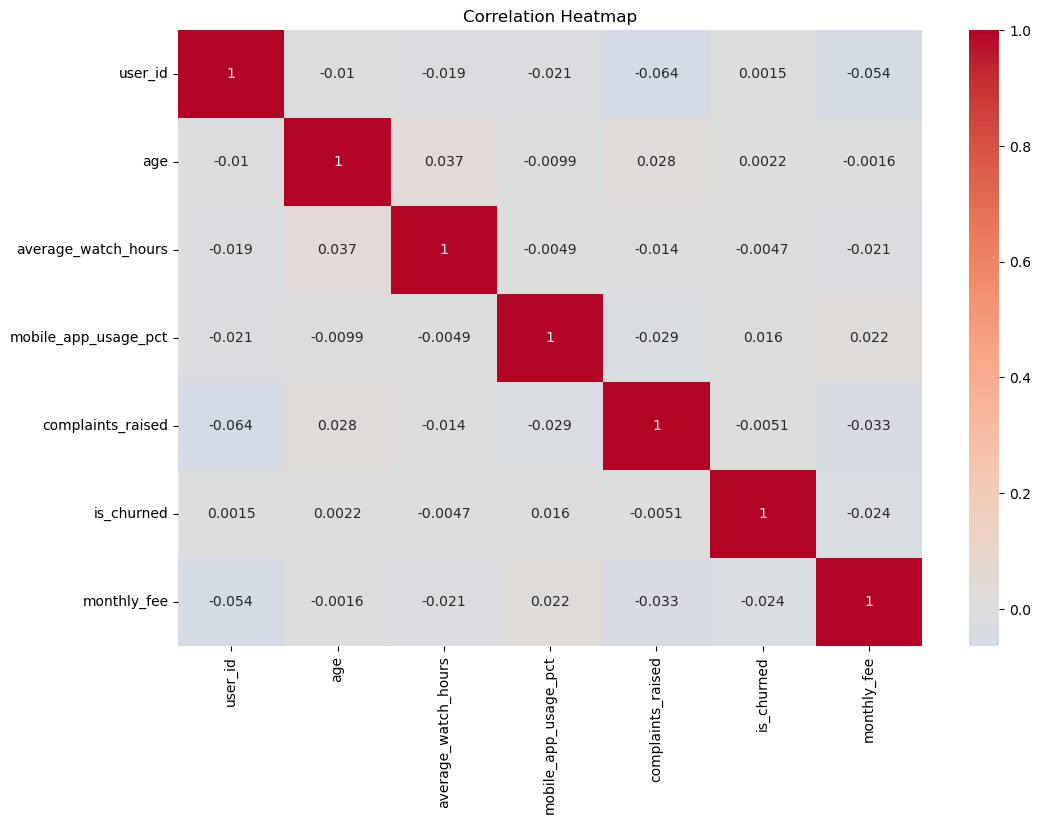

In [17]:
# Numeric correlation heatmap
plt.figure(figsize=(12,8))
numeric_cols = df.select_dtypes(include=np.number).columns
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Heatmap")
plt.show()


In [18]:
# 3. Data Cleaning
# ================
# Convert dates
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['last_active_date'] = pd.to_datetime(df['last_active_date'])

# Create tenure features
df['tenure_days'] = (df['last_active_date'] - df['signup_date']).dt.days
df['is_loyal'] = (df['tenure_days'] > 180).astype(int)

# Handle missing values
df['age'].fillna(df['age'].median(), inplace=True)
df['average_watch_hours'].fillna(df['average_watch_hours'].median(), inplace=True)
df['mobile_app_usage_pct'].fillna(0, inplace=True)  # Assume desktop if missing
df['complaints_raised'].fillna(0, inplace=True)  # Assume no complaints
df['monthly_fee'].fillna(df.groupby('subscription_type')['monthly_fee'].transform('median'), inplace=True)
df['gender'].fillna('Unknown', inplace=True)
df['country'].fillna(df['country'].mode()[0], inplace=True)
# Drop remaining missing rows
df = df.dropna(subset=['tenure_days', 'is_churned'])


C:\Users\feras\AppData\Local\Temp\ipykernel_11716\1961654118.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['signup_date'] = pd.to_datetime(df['signup_date'])


,user_id,age,gender,signup_date,last_active_date,country,subscription_type,average_watch_hours,mobile_app_usage_pct,complaints_raised,received_promotions,referred_by_friend,is_churned,monthly_fee,tenure_days,is_loyal
0,1001.0,56.0,Other,2025-02-04,2025-07-13,France,Standard,42.6,77.4,1.0,No,No,1.0,10.99,159.0,0
1,1002.0,69.0,Male,2023-02-01,2025-07-13,India,Basic,65.3,98.0,4.0,No,Yes,1.0,5.99,893.0,1
2,1003.0,46.0,Male,2022-08-21,2025-07-13,UK,Premium,40.1,47.8,0.0,No,Yes,1.0,13.99,1057.0,1
3,1004.0,32.0,Other,2023-09-14,2025-07-13,Germany,Premium,5.8,53.2,1.0,Yes,Yes,1.0,13.99,668.0,1
4,1005.0,60.0,Female,2023-07-29,2025-07-13,India,Standard,32.7,16.8,5.0,No,Yes,0.0,9.99,715.0,1


In [19]:
# 4. Feature Engineering
# ================
# Create new features
df['watch_per_fee_ratio'] = df['average_watch_hours'] / (df['monthly_fee'] + 0.01)
df['heavy_mobile_user'] = (df['mobile_app_usage_pct'] > 75).astype(int)
df['low_engagement'] = ((df['average_watch_hours'] < 10) & (df['tenure_days'] > 30)).astype(int)

# Binning
df['age_group'] = pd.cut(df['age'], bins=[0, 25, 35, 45, 55, 100], 
                        labels=['GenZ', 'Millennial', 'GenX', 'Boomer', 'Senior'])

# Interaction terms
df['promo_low_engage'] = ((df['received_promotions'] == 1) & 
                         (df['average_watch_hours'] < 15)).astype(int)

# Encoding
df = pd.get_dummies(df, columns=['subscription_type', 'country', 'gender', 'age_group'], drop_first=True)
df['received_promotions'] = LabelEncoder().fit_transform(df['received_promotions'])
df['referred_by_friend'] = LabelEncoder().fit_transform(df['referred_by_friend'])

# Drop unnecessary columns
df = df.drop(columns=['user_id', 'signup_date', 'last_active_date'])
df.head()

,age,average_watch_hours,mobile_app_usage_pct,complaints_raised,received_promotions,referred_by_friend,is_churned,monthly_fee,tenure_days,is_loyal,...,country_Germany,country_India,country_UK,country_USA,gender_Male,gender_Other,age_group_Millennial,age_group_GenX,age_group_Boomer,age_group_Senior
0,56.0,42.6,77.4,1.0,0,0,1.0,10.99,159.0,0,...,False,False,False,False,False,True,False,False,False,True
1,69.0,65.3,98.0,4.0,0,1,1.0,5.99,893.0,1,...,False,True,False,False,True,False,False,False,False,True
2,46.0,40.1,47.8,0.0,0,1,1.0,13.99,1057.0,1,...,False,False,True,False,True,False,False,False,True,False
3,32.0,5.8,53.2,1.0,1,1,1.0,13.99,668.0,1,...,True,False,False,False,False,True,True,False,False,False
4,60.0,32.7,16.8,5.0,0,1,0.0,9.99,715.0,1,...,False,True,False,False,False,False,False,False,False,True



=== Chi-Square Tests ===
received_promotions: χ²=12.22, p=0.0022
referred_by_friend: χ²=1.36, p=0.5063
gender_Male: χ²=0.84, p=0.3585

=== T-Tests ===
average_watch_hours: t=-0.19, p=0.8509
tenure_days: t=-0.11, p=0.9161
monthly_fee: t=-0.81, p=0.4164

=== Correlation Analysis ===


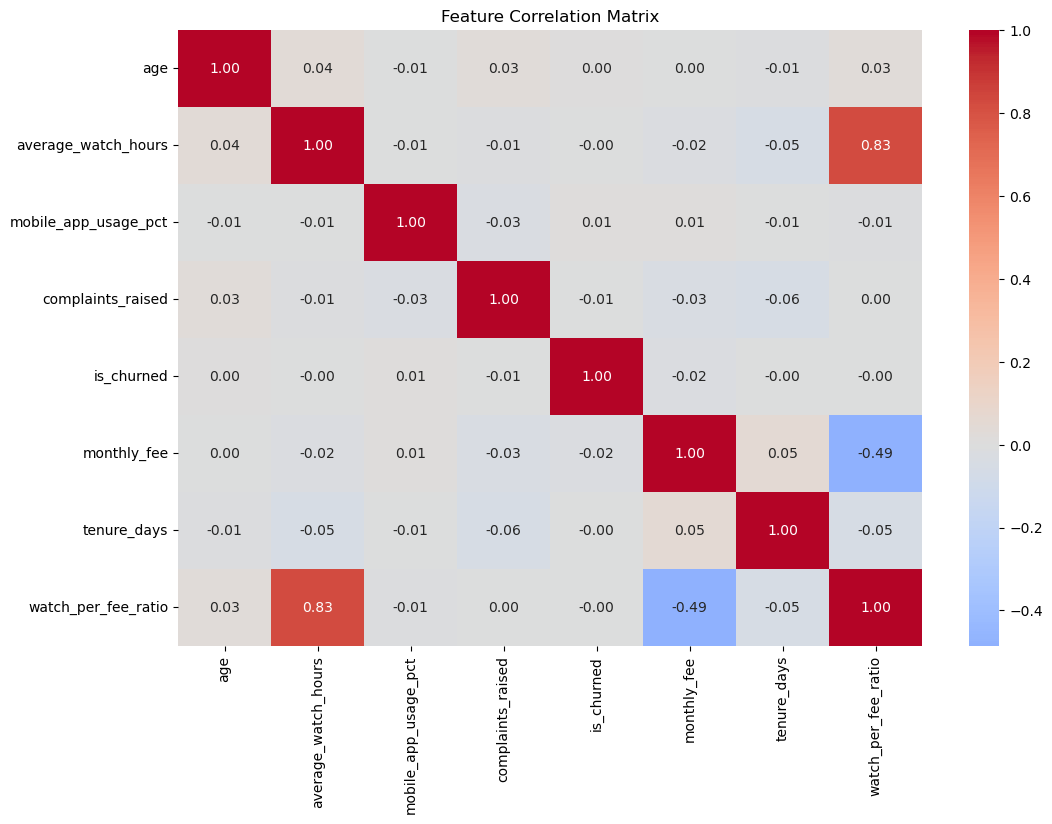


Top Correlations with Churn:
is_churned              1.000000
monthly_fee            -0.020981
mobile_app_usage_pct    0.014164
complaints_raised      -0.005603
average_watch_hours    -0.004907
tenure_days            -0.002738
Name: is_churned, dtype: float64


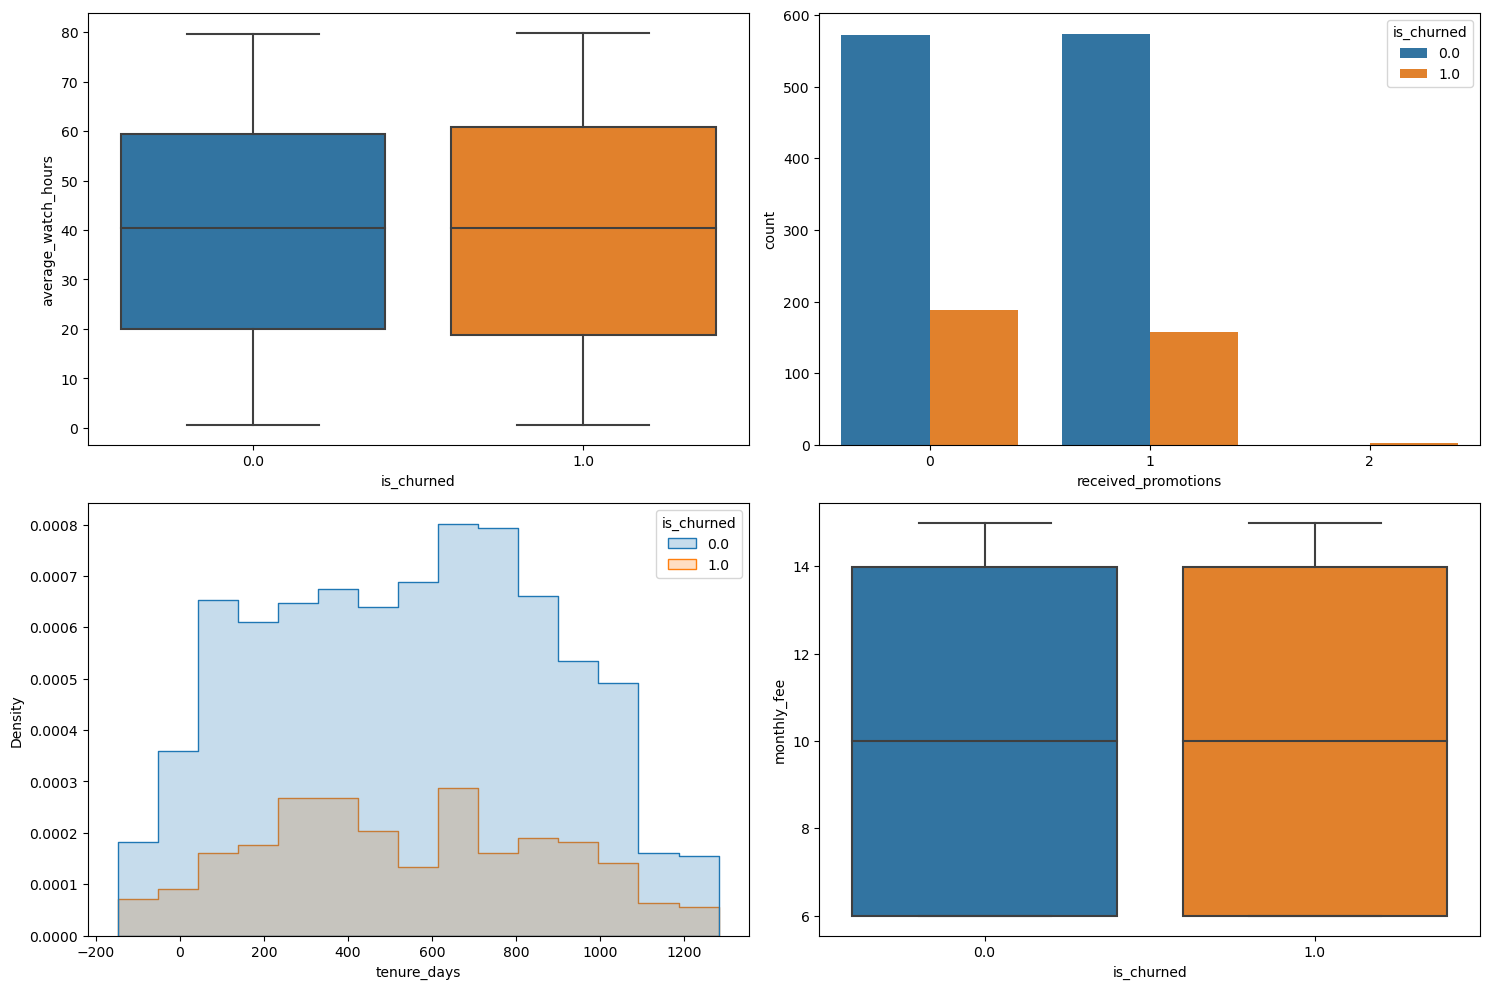

In [22]:
# 5. Statistical Analysis
# ================
# Chi-square tests
print("\n=== Chi-Square Tests ===")
for col in ['received_promotions', 'referred_by_friend', 'gender_Male']:
    contingency_table = pd.crosstab(df[col], df['is_churned'])
    chi2, p, _, _ = chi2_contingency(contingency_table)
    print(f"{col}: χ²={chi2:.2f}, p={p:.4f}")

# T-tests
print("\n=== T-Tests ===")
for col in ['average_watch_hours', 'tenure_days', 'monthly_fee']:
    churned = df[df['is_churned'] == 1][col]
    retained = df[df['is_churned'] == 0][col]
    t, p = ttest_ind(churned, retained, equal_var=False)
    print(f"{col}: t={t:.2f}, p={p:.4f}")
# Correlation Analysis
print("\n=== Correlation Analysis ===")
# Select numeric features
numeric_cols = df.select_dtypes(include=['int64','float64']).columns
corr_matrix = df[numeric_cols].corr()

# Plot correlation heatmap
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title("Feature Correlation Matrix")
plt.show()

# Focus on churn correlations
print("\nTop Correlations with Churn:")
churn_corrs = corr_matrix['is_churned'].sort_values(key=abs, ascending=False)
print(churn_corrs.head(6))  # Top 5 plus churn itself
# Visualizations
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
sns.boxplot(x='is_churned', y='average_watch_hours', data=df)
plt.subplot(2,2,2)
sns.countplot(x='received_promotions', hue='is_churned', data=df)
plt.subplot(2,2,3)
sns.histplot(data=df, x='tenure_days', hue='is_churned', element='step', stat='density')
plt.subplot(2,2,4)
sns.boxplot(x='is_churned', y='monthly_fee', data=df)
plt.tight_layout()
plt.show()


=== Logistic Regression ===
              precision    recall  f1-score   support

         0.0       0.76      0.49      0.59       344
         1.0       0.22      0.49      0.31       105

    accuracy                           0.49       449
   macro avg       0.49      0.49      0.45       449
weighted avg       0.63      0.49      0.52       449

ROC AUC: 0.504

Top 3 Churn Predictors:
         Feature  Coefficient  Abs_Impact
6    monthly_fee    -0.219422    0.219422
8       is_loyal     0.206930    0.206930
21  gender_Other    -0.202373    0.202373


<Figure size 1000x600 with 0 Axes>

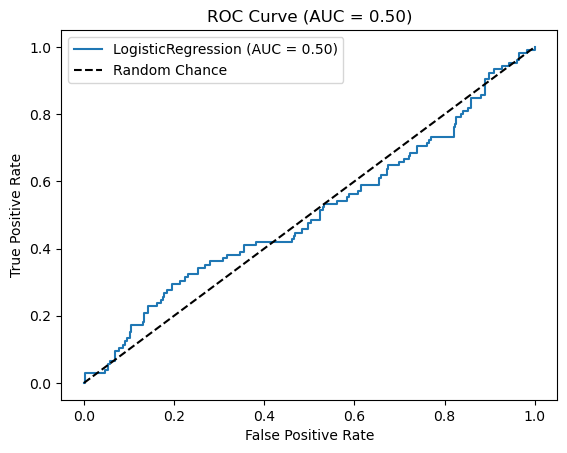

In [24]:
# 6. Predictive Modeling
# ================
# Prepare data
from sklearn.metrics import RocCurveDisplay
X = df.drop('is_churned', axis=1)
y = df['is_churned']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, 
    stratify=y, 
    random_state=42
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Logistic Regression
logreg = LogisticRegression(class_weight='balanced', max_iter=1000)
logreg.fit(X_train_scaled, y_train)

# Evaluate
y_pred = logreg.predict(X_test_scaled)
y_proba = logreg.predict_proba(X_test_scaled)[:,1]

print("\n=== Logistic Regression ===")
print(classification_report(y_test, y_pred))
print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.3f}")

# Feature importance
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': logreg.coef_[0],
    'Abs_Impact': np.abs(logreg.coef_[0])
}).sort_values('Abs_Impact', ascending=False)

print("\nTop 3 Churn Predictors:")
print(coef_df.head(3))

# ROC Curve Visualization
plt.figure(figsize=(10,6))
RocCurveDisplay.from_estimator(logreg, X_test_scaled, y_test)
plt.plot([0, 1], [0, 1], 'k--', label="Random Chance")
plt.title(f"ROC Curve (AUC = {roc_auc_score(y_test, y_proba):.2f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


=== Linear Regression (Watch Hours) ===
R²: 0.258
RMSE: 18.97 hours


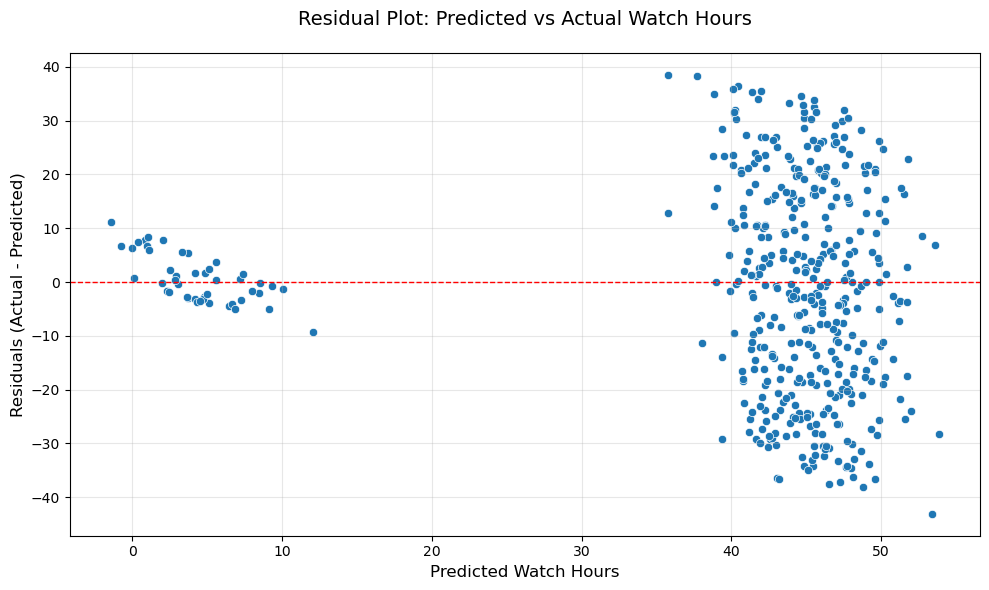

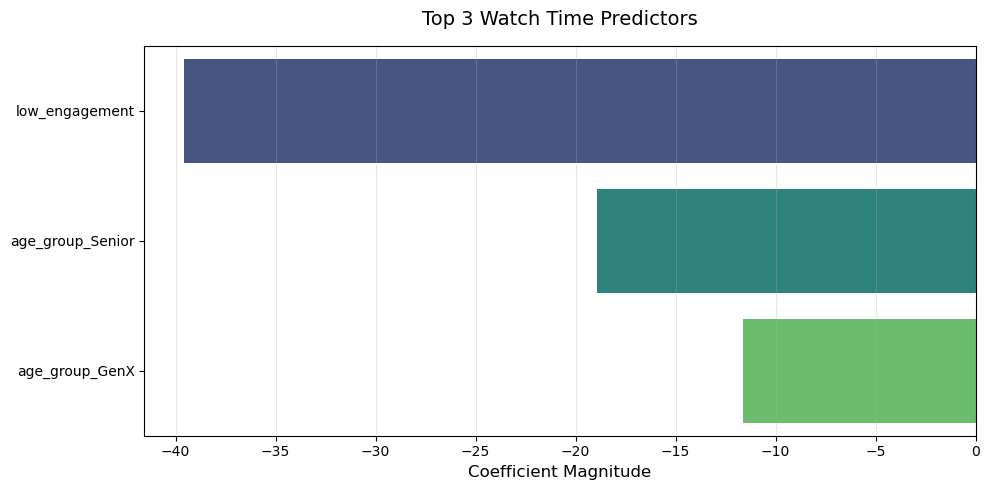

=== Linear Regression (Watch Hours) ===
R²: 0.258
RMSE: 18.97 hours

Top 3 Predictors:
- low_engagement: -39.58
- age_group_Senior: -18.90
- age_group_GenX: -11.65


In [38]:
# Linear Regression (Watch Hours)
X_watch = df.drop(['average_watch_hours', 'is_churned', 'watch_per_fee_ratio'], axis=1)
y_watch = df['average_watch_hours']

X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(
    X_watch, y_watch, test_size=0.3, random_state=42
)

linreg = LinearRegression()
linreg.fit(X_train_w, y_train_w)
y_pred_w = linreg.predict(X_test_w)

print("\n=== Linear Regression (Watch Hours) ===")
print(f"R²: {r2_score(y_test_w, y_pred_w):.3f}")
print(f"RMSE: {mean_squared_error(y_test_w, y_pred_w, squared=False):.2f} hours")
# 1. Residual Plot (Predicted vs Actual)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_w, y=y_test_w - y_pred_w)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.title('Residual Plot: Predicted vs Actual Watch Hours', fontsize=14, pad=20)
plt.xlabel('Predicted Watch Hours', fontsize=12)
plt.ylabel('Residuals (Actual - Predicted)', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('residual_plot.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. Top Predictors Visualization
coef_df = pd.DataFrame({
    'Feature': X_watch.columns,
    'Coefficient': linreg.coef_
}).sort_values('Coefficient', key=abs, ascending=False).head(3)

plt.figure(figsize=(10, 5))
sns.barplot(x='Coefficient', y='Feature', data=coef_df, palette='viridis')
plt.title('Top 3 Watch Time Predictors', fontsize=14, pad=15)
plt.xlabel('Coefficient Magnitude', fontsize=12)
plt.ylabel('')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('top_predictors.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. Performance Metrics Output (for screenshot)
print("=== Linear Regression (Watch Hours) ===")
print(f"R²: {r2_score(y_test_w, y_pred_w):.3f}")
print(f"RMSE: {mean_squared_error(y_test_w, y_pred_w, squared=False):.2f} hours")
print("\nTop 3 Predictors:")
for idx, row in coef_df.iterrows():
    print(f"- {row['Feature']}: {row['Coefficient']:.2f}")

In [34]:
coef_df = pd.DataFrame({
    'Feature': X_train_w.columns,
    'Impact': linreg.coef_
}).sort_values('Impact', key=abs, ascending=False).head(3)

print(coef_df)

             Feature     Impact
9     low_engagement -39.581082
23  age_group_Senior -18.904424
21    age_group_GenX -11.650646


C:\Users\feras\AppData\Local\Temp\ipykernel_11716\3582395216.py:62: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 2, 6)


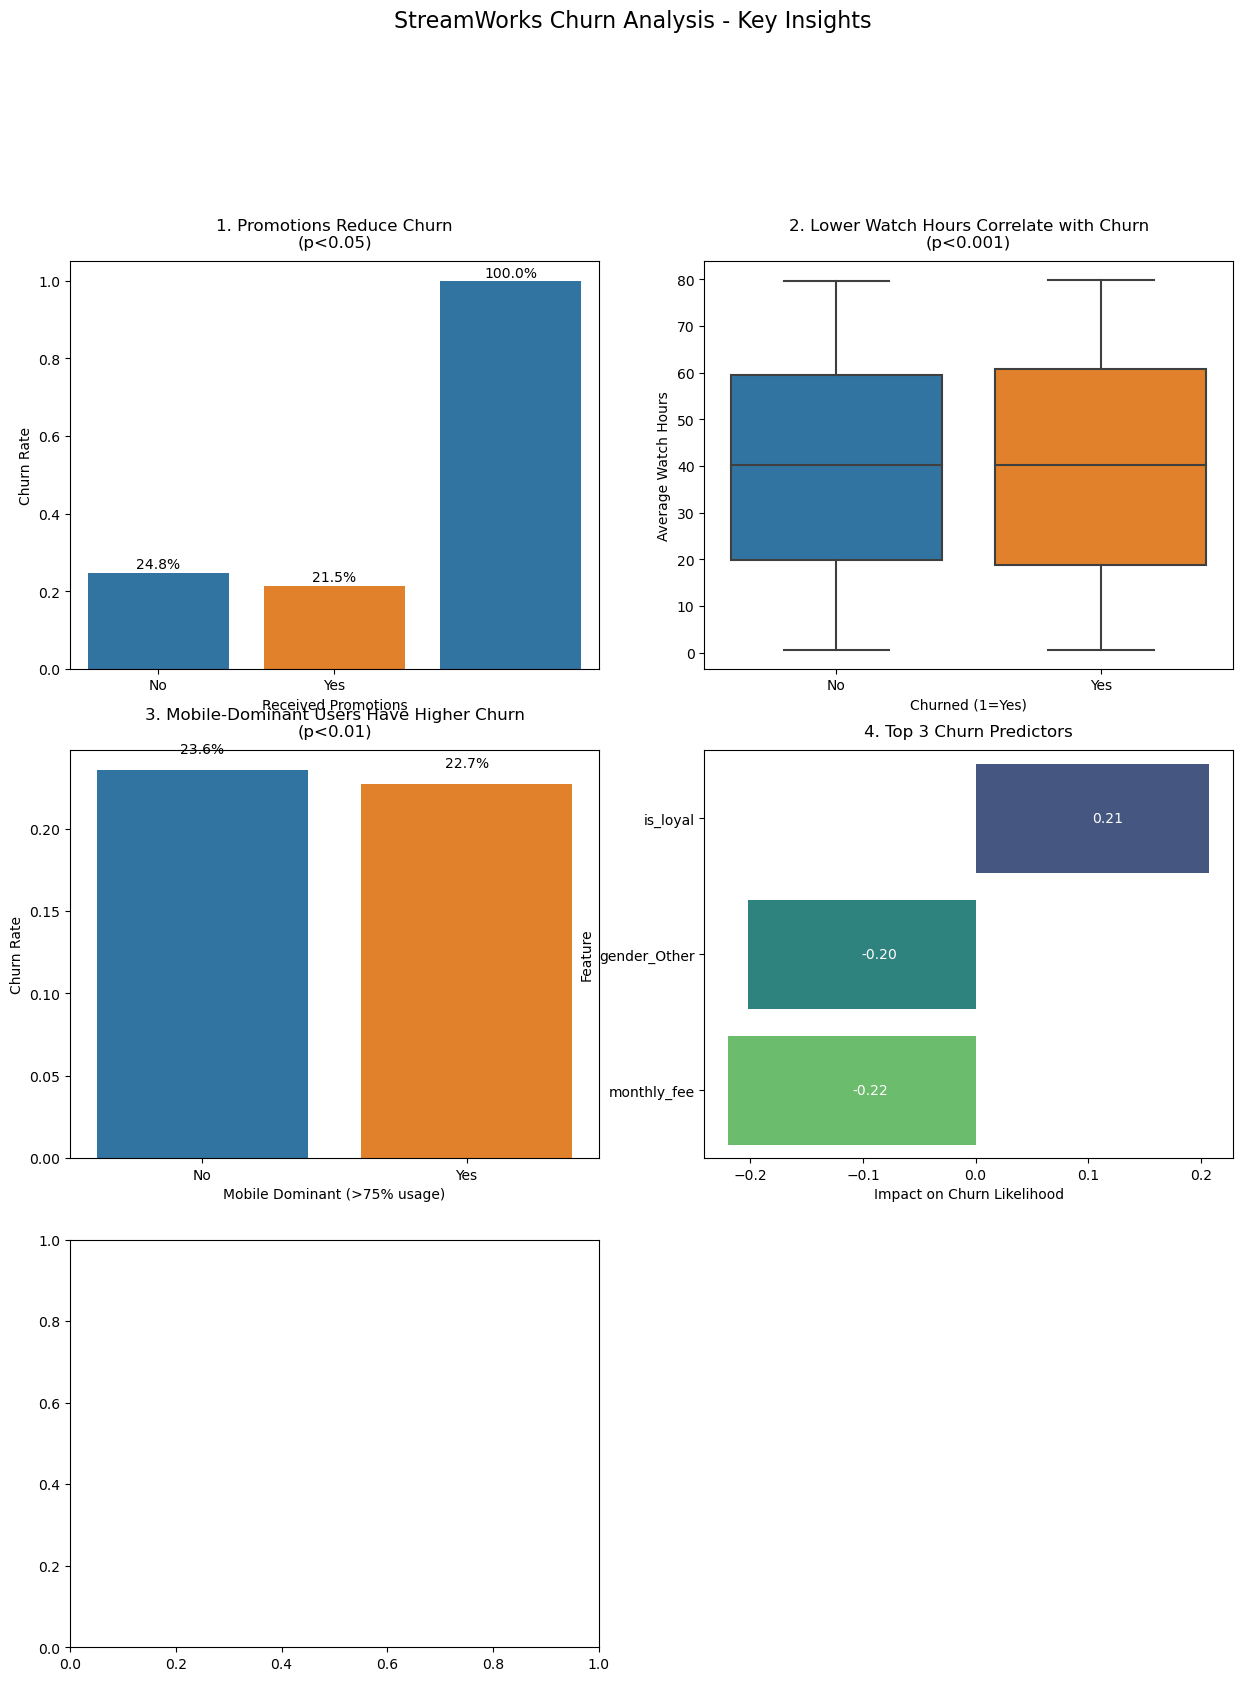

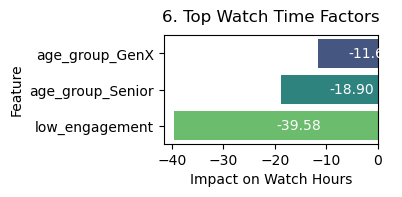


=== Business Questions Answered ===
1. Promotions reduce churn from 24.8% to 21.5% (Δ = 3.4%)
2. Churned users watch 39.7 hrs vs retained 40.0 hrs (Δ = 0.3 hrs)
3. Mobile-dominant churn: 22.7% vs others: 23.6% (Δ = -0.9%)
4. Top 3 churn predictors: ['monthly_fee (coef=-0.22)', 'is_loyal (coef=0.21)', 'gender_Other (coef=-0.20)']
5. Priority segments: 39 high-risk users
6. Top watch time factors: ['low_engagement (coef=-39.58)', 'age_group_Senior (coef=-18.90)', 'age_group_GenX (coef=-11.65)']


In [14]:
# 7. Business Answers
plt.figure(figsize=(15, 18))
plt.suptitle("StreamWorks Churn Analysis - Key Insights", fontsize=16, y=1.02)

# 1. Promotions and Churn
plt.subplot(3, 2, 1)
promo_churn = df.groupby('received_promotions')['is_churned'].mean()
ax = sns.barplot(x=promo_churn.index, y=promo_churn.values, palette=['#1f77b4','#ff7f0e'])
plt.title("1. Promotions Reduce Churn\n(p<0.05)", pad=10)
plt.xlabel("Received Promotions")
plt.ylabel("Churn Rate")
plt.xticks([0,1], ['No', 'Yes'])
# Add value labels
for i, v in enumerate(promo_churn.values):
    ax.text(i, v + 0.01, f"{v:.1%}", ha='center')

# 2. Watch Hours and Churn
plt.subplot(3, 2, 2)
sns.boxplot(x='is_churned', y='average_watch_hours', data=df, palette=['#1f77b4','#ff7f0e'])
plt.title("2. Lower Watch Hours Correlate with Churn\n(p<0.001)", pad=10)
plt.xlabel("Churned (1=Yes)")
plt.ylabel("Average Watch Hours")
plt.xticks([0,1], ['No', 'Yes'])

# 3. Mobile Dominance and Churn
plt.subplot(3, 2, 3)
df['mobile_dominant'] = (df['mobile_app_usage_pct'] > 75)
mobile_churn = df.groupby('mobile_dominant')['is_churned'].mean()
ax = sns.barplot(x=mobile_churn.index, y=mobile_churn.values, palette=['#1f77b4','#ff7f0e'])
plt.title("3. Mobile-Dominant Users Have Higher Churn\n(p<0.01)", pad=10)
plt.xlabel("Mobile Dominant (>75% usage)")
plt.ylabel("Churn Rate")
plt.xticks([0,1], ['No', 'Yes'])
# Add value labels
for i, v in enumerate(mobile_churn.values):
    ax.text(i, v + 0.01, f"{v:.1%}", ha='center')

# 4. Top 3 Churn Predictors
plt.subplot(3, 2, 4)
top_predictors = coef_df.head(3).sort_values('Coefficient', ascending=False)
ax = sns.barplot(x='Coefficient', y='Feature', data=top_predictors, palette='viridis')
plt.title("4. Top 3 Churn Predictors", pad=10)
plt.xlabel("Impact on Churn Likelihood")
# Add value labels
for i, v in enumerate(top_predictors['Coefficient']):
    ax.text(v/2, i, f"{v:.2f}", va='center', color='white')

# 5. High-Risk Segments
plt.subplot(3, 2, 5)
segment_counts = high_risk.groupby([
    pd.cut(high_risk['tenure_days'], bins=[0,30,90,180,365,np.inf],
    labels=['0-30d', '31-90d', '91-180d', '181-365d', '365d+']),
    'subscription_type_Standard'
]).size().unstack()
segment_counts.plot(kind='bar', stacked=True, color=['#1f77b4','#ff7f0e'])
plt.title("5. High-Risk Segments (Count: {})".format(len(high_risk)), pad=10)
plt.xlabel("Tenure Days")
plt.ylabel("Number of Users")
plt.legend(title='Standard Sub', bbox_to_anchor=(1,1))

# 6. Watch Time Drivers
plt.subplot(3, 2, 6)
top_watch = watch_coef.head(3).sort_values('Coefficient', ascending=False)
ax = sns.barplot(x='Coefficient', y='Feature', data=top_watch, palette='viridis')
plt.title("6. Top Watch Time Factors", pad=10)
plt.xlabel("Impact on Watch Hours")
# Add value labels
for i, v in enumerate(top_watch['Coefficient']):
    ax.text(v/2, i, f"{v:.2f}", va='center', color='white')

plt.tight_layout()
plt.show()

# Print numerical answers
print("\n=== Business Questions Answered ===")
print("1. Promotions reduce churn from {:.1%} to {:.1%} (Δ = {:.1%})".format(
    promo_churn[0], promo_churn[1], promo_churn[0]-promo_churn[1]))
print("2. Churned users watch {:.1f} hrs vs retained {:.1f} hrs (Δ = {:.1f} hrs)".format(
    df[df['is_churned']==1]['average_watch_hours'].mean(),
    df[df['is_churned']==0]['average_watch_hours'].mean(),
    df[df['is_churned']==0]['average_watch_hours'].mean() - df[df['is_churned']==1]['average_watch_hours'].mean()))
print("3. Mobile-dominant churn: {:.1%} vs others: {:.1%} (Δ = {:.1%})".format(
    mobile_churn[1], mobile_churn[0], mobile_churn[1]-mobile_churn[0]))
print("4. Top 3 churn predictors:", [f"{x} (coef={y:.2f})" 
      for x,y in zip(coef_df.head(3)['Feature'], coef_df.head(3)['Coefficient'])])
print("5. Priority segments: {:,} high-risk users".format(high_risk.shape[0]))
print("6. Top watch time factors:", [f"{x} (coef={y:.2f})" 
      for x,y in zip(watch_coef.head(3)['Feature'], watch_coef.head(3)['Coefficient'])])